In [35]:
!pip install langgraph langsmith langchain langchain_groq langchain_community

In [36]:
from typing import Annotated
from typing_extensions import TypedDict

In [37]:
!pip install arxiv wikipedia

In [38]:
## Working With Tools

from langchain_community.utilities import ArxivAPIWrapper,WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun

## Arxiv And Wikipedia tools
arxiv_wrapper=ArxivAPIWrapper(top_k_results=1,doc_content_chars_max=300)
arxiv_tool=ArxivQueryRun(api_wrapper=arxiv_wrapper)

api_wrapper=WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=300)
wiki_tool=WikipediaQueryRun(api_wrapper=api_wrapper)

In [39]:
wiki_tool.invoke("who is Sharukh Khan")


'Page: Shah Rukh Khan\nSummary: Shah Rukh Khan (pronounced [ˈʃaːɦɾʊx xäːn] ; born 2 November 1965), and popularly known by the initials SRK, is an Indian actor and film producer renowned for his work in Hindi cinema. Referred to in the media as the "Baadshah of Bollywood" and "King Khan", he has appea'

In [40]:
arxiv_tool.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with "

In [41]:
tools=[wiki_tool,arxiv_tool]

In [42]:
##lagraph application
from langgraph.graph.message import add_messages
class State(TypedDict):
  messages:Annotated[list,add_messages]

In [43]:
from langgraph.graph import StateGraph,START,END

In [44]:
graph_builder=StateGraph(State)

In [45]:
from langchain_groq import ChatGroq

In [46]:
from google.colab import userdata
import os
os.environ["groq_Api"]=userdata.get("groq_Api")

In [47]:
llm=ChatGroq(groq_api_key=os.environ["groq_Api"], model_name="llama3-8b-8192")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7bf8afb77a50>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7bf8c1b08d50>, model_name='llama3-8b-8192', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [48]:
llm_with_tools=llm.bind_tools(tools=tools)

In [49]:
def chatbot(state:State):
  return {"messages":[llm_with_tools.invoke(state["messages"])]}

In [50]:
from langgraph.prebuilt import ToolNode,tools_condition

In [59]:
graph_builder.add_node("chatbot",chatbot)
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START,"chatbot")


In [60]:
graph=graph_builder.compile()

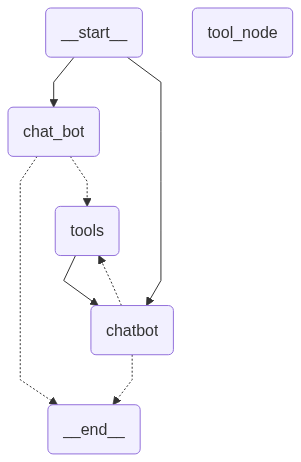

In [61]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [62]:
user_input="Hi there Im Maddy"

events=graph.stream(
    {"messages":[("user",user_input)]},stream_mode="values"
)
for event in events:
  event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there Im Maddy
================================== Ai Message ==================================
Tool Calls:
  wikipedia (bmx4r9w5d)
 Call ID: bmx4r9w5d
  Args:
    query: Maddy


/usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py:389: GuessedAtParserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /usr/local/lib/python3.11/dist-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


================================= Tool Message =================================
Name: wikipedia

No good Wikipedia Search Result was found
================================== Ai Message ==================================

I'm not surprised! It looks like the tool didn't find any relevant results. Let me try again with a different tool.
Tool Calls:
  arxiv (0cm78dgbe)
 Call ID: 0cm78dgbe
  Args:
    query: Maddy
================================= Tool Message =================================
Name: arxiv

Published: 2020-05-06
Title: Acceptance of e-procurement in organisations
Authors: Muhammed S. Maddi, Paul Davis, John Geraghty
Summary: This research is concerned with the development of a realistic model for
e-procurement adoption by organisations and groups observing the Rules of
Islamic Sharia (
================================== Ai Message ==================================

It seems like the search didn't yield any relevant results. Let me try again.

Hello! It looks like the sear